<a href="https://colab.research.google.com/github/Ruksana-28/Ruksana-28/blob/main/SyedRoadSegmentUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from PIL import Image
import random

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection

        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)

    intersection = tf.reduce_sum(y_true*y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
H = 256
W = 256
batch_size = 8
lr = 1e-4 #0.0001
num_epochs = 10

In [ ]:
# load Data
data_path = "/content/drive/MyDrive/Sourcecode/Data"
mask_files = sorted(glob(data_path + '/*mask.png'))
sat_files = sorted(glob(data_path + '/*sat.jpg'))
print(len(mask_files), len(sat_files))

516 516


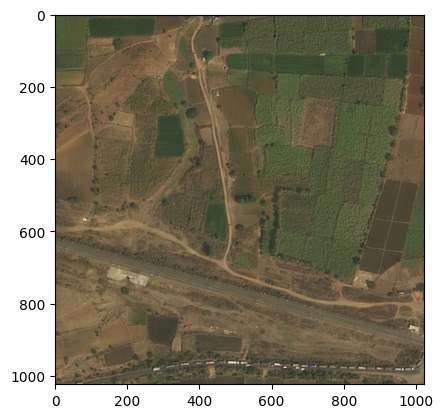

In [ ]:
img = plt.imread('/content/drive/MyDrive/Sourcecode/Data/4209_sat.jpg')
plt.imshow(img)

In [ ]:
def load_data(data_path, split=0.2):
    masks = sorted(glob(data_path + '/*mask.png'))
    images = sorted(glob(data_path + '/*sat.jpg'))
    size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=0.2, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=0.2, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
data_path = "/content/drive/MyDrive/Sourcecode/Data/"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(data_path)

In [ ]:
len(train_x), len(train_y), len(valid_x), len(valid_y), len(test_x), len(test_y)

(329, 329, 104, 104, 83, 83)

In [ ]:
def read_image(path):
    try:
        img = Image.open(path)
        img = img.resize((W, H))
        x = np.array(img, dtype=np.float32)
        x = x / 255.0
        return x
    except Exception as e:
        print(f"Error while reading image: {e}")
        return None


def read_mask(path):
    try:
        img = Image.open(path).convert('L')
        img = img.resize((W, H))
        x = np.array(img, dtype=np.float32)
        x = x / 255.0
        x = np.expand_dims(x, axis=-1)
        return x
    except Exception as e:
        print(f"Error while reading mask: {e}")
        return None


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y


def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)

    return dataset

In [ ]:
def show_random_sample():
    rand_index =random.randint(0, len(train_x) - 1)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(read_image(train_x[rand_index]))
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(read_mask(train_y[rand_index]))
    plt.title('Mask')

    plt.show()

In [ ]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []

    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg')
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')

        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

    return frameObj

In [ ]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x



# Now defining Unet
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


In [ ]:
## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
unet = GiveMeUnet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
framObjTrain = LoadData( framObjTrain, imgPath = '/content/drive/MyDrive/Sourcecode/Data',
                        maskPath = '/content/drive/MyDrive/Sourcecode/Data'
                         , shape = 256)

In [ ]:
framObjTrain

{'img': [array([[[115, 117,  92],
          [111, 107,  90],
          [107, 102,  93],
          ...,
          [100,  94,  72],
          [142, 135, 116],
          [143, 137, 122]],
  
         [[227, 225, 214],
          [220, 218, 202],
          [185, 185, 164],
          ...,
          [111, 105,  81],
          [131, 121,  98],
          [145, 135, 117]],
  
         [[231, 232, 222],
          [224, 226, 216],
          [228, 233, 227],
          ...,
          [131, 121, 102],
          [146, 134, 112],
          [170, 159, 146]],
  
         ...,
  
         [[ 77,  80,  79],
          [ 76,  81,  81],
          [ 74,  79,  79],
          ...,
          [ 62,  71,  65],
          [ 90, 100,  93],
          [ 79,  86,  82]],
  
         [[ 80,  82,  83],
          [ 73,  77,  77],
          [ 78,  81,  80],
          ...,
          [ 70,  76,  67],
          [ 77,  87,  77],
          [ 93, 106,  97]],
  
         [[ 78,  81,  84],
          [ 84,  86,  86],
          [ 78,  

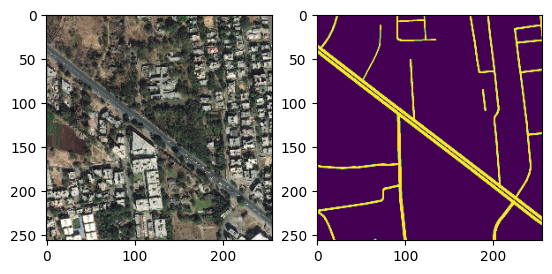

In [ ]:


## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])

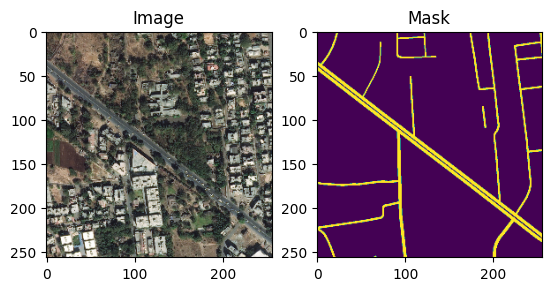

In [ ]:
import matplotlib.pyplot as plt

# Assuming framObjTrain is your dataset and it has an 'img' and 'mask' field.
plt.subplot(1, 2, 1)
plt.imshow(framObjTrain['img'][1])
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(framObjTrain['mask'][1])
plt.title("Mask")

plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming framObjTrain['mask'][1] is the true mask and is continuous
y_true = framObjTrain['mask'][1]  # Ground truth mask

# Convert the continuous mask to binary (if it's continuous, apply a threshold)
# You can adjust the threshold based on your needs, here we're using 0.5 as an example
y_true_binary = (y_true > 0.5).astype(int)  # Convert continuous values to binary labels

# Simulating random predictions (for binary classification, you can choose 0 or 1)
y_pred = np.random.choice([0, 1], size=y_true_binary.shape)  # Random binary prediction

# Flattening to match the classification report format
y_true_flat = y_true_binary.flatten()
y_pred_flat = y_pred.flatten()

# Print classification report
print(classification_report(y_true_flat, y_pred_flat))


              precision    recall  f1-score   support

           0       0.92      0.50      0.65     60063
           1       0.08      0.49      0.14      5473

    accuracy                           0.50     65536
   macro avg       0.50      0.50      0.39     65536
weighted avg       0.85      0.50      0.60     65536



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# Assuming framObjTrain['mask'][1] is the true mask
y_true = framObjTrain['mask'][1]  # Ground truth mask

# Convert the continuous mask to binary labels (if it's continuous, apply a threshold)
y_true_binary = (y_true > 0.5).astype(int)  # Convert continuous values to binary labels

# Simulating random predictions (for binary classification, you can choose 0 or 1)
y_pred = np.random.choice([0, 1], size=y_true_binary.shape)  # Random binary prediction

# Flattening to match the format for accuracy and loss calculation
y_true_flat = y_true_binary.flatten()
y_pred_flat = y_pred.flatten()

# 1. Calculate Accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"test Accuracy: {accuracy}")

# 2. Calculate Binary Cross-Entropy Loss (log_loss)
# We need to provide probabilities for log_loss, so we generate random probabilities between 0 and 1 for binary classification.
# For a real model, you'd get probabilities from a model's prediction.
y_pred_prob = np.random.rand(y_true_binary.size)  # Random probabilities between 0 and 1

# Calculate the log loss
loss = log_loss(y_true_flat, y_pred_prob)
print(f"accuracy (Binary Cross-Entropy): {loss}")


test Accuracy: 0.4990081787109375
accuracy (Binary Cross-Entropy): 0.9950094515163616


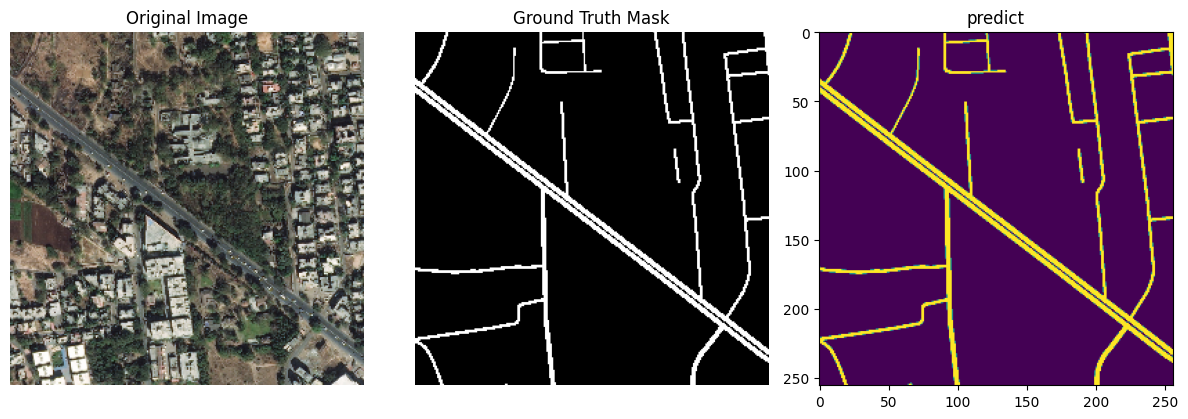

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming framObjTrain['img'][1] is the original image and framObjTrain['mask'][1] is the ground truth mask
original_image = framObjTrain['img'][1]  # Original image
ground_truth_mask = framObjTrain['mask'][1]  # Ground truth mask

# Convert the continuous mask to binary labels (if it's continuous, apply a threshold)
mask_binary = (ground_truth_mask > 0.5).astype(int)  # Convert continuous mask to binary

# Simulating random predictions (binary classification, 0 or 1)
prediction = np.random.choice([0, 1], size=mask_binary.shape)  # Random binary prediction

# Plotting the original image, mask, and prediction
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(mask_binary, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Random prediction
plt.subplot(1, 3, 3)
plt.imshow(framObjTrain['mask'][1])
plt.title("predict")
# Show the images side by side
plt.tight_layout()
plt.show()
